<a href="https://colab.research.google.com/github/KateT840/Laboratorio_moderna/blob/main/Lab_2/Codigo_Lab_2_hidrogeno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import os
from google.colab import drive
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
os.chdir("/content/drive/MyDrive/Laboratorio_moderna/")
!ls

 Lab1  'Lab 2'


In [17]:
file = '/content/drive/MyDrive/Laboratorio_moderna/Lab2/Espectro_H.csv'
file

'/content/drive/MyDrive/Laboratorio_moderna/Lab2/Espectro_H.csv'

In [18]:
df = pd.read_csv(file)

In [22]:
df = pd.read_csv(file, sep=',', decimal='.', header=None)
df.columns = ['Distance_(pixels)', 'Gray_Value']

print(df.head())
print(df.dtypes)

   Distance_(pixels)  Gray_Value
0  Distance_(pixels)  Gray_Value
1                  0     151.000
2                  1     151.000
3                  2     151.000
4                  3     151.000
Distance_(pixels)    object
Gray_Value           object
dtype: object


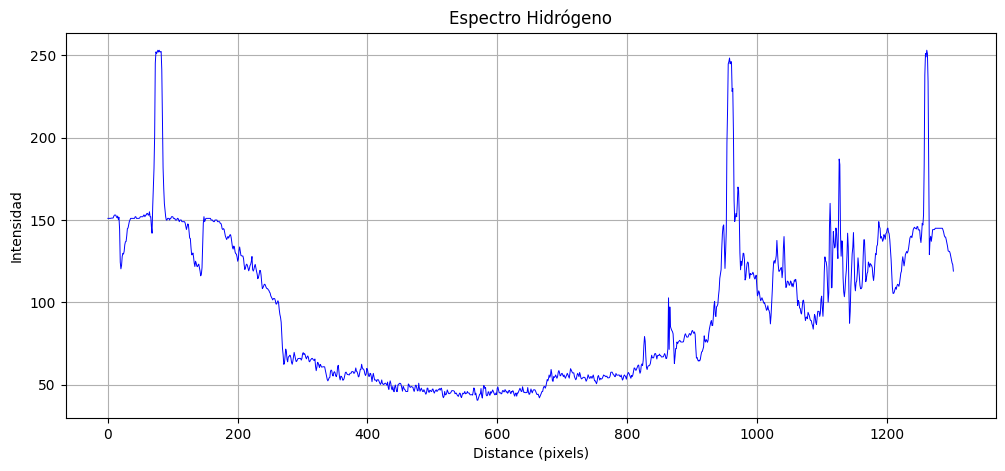

In [27]:
# Asegurar que las columnas sean numéricas
df["Distance_(pixels)"] = pd.to_numeric(df["Distance_(pixels)"], errors="coerce")
df["Gray_Value"] = pd.to_numeric(df["Gray_Value"], errors="coerce")
df = df.dropna()

# --- Graficar espectro H (sin invertir) ---
x = df["Distance_(pixels)"].values
y = df["Gray_Value"].values

plt.figure(figsize=(12,5))
plt.plot(x, y, linewidth=0.7, color="blue")
plt.xlabel("Distance (pixels)")
plt.ylabel("Intensidad")
plt.title("Espectro Hidrógeno")
plt.grid(True)
plt.show()


Primer pico en el rango 0–200 pixeles:
Pixel = 143.0, Intensidad = 116.159


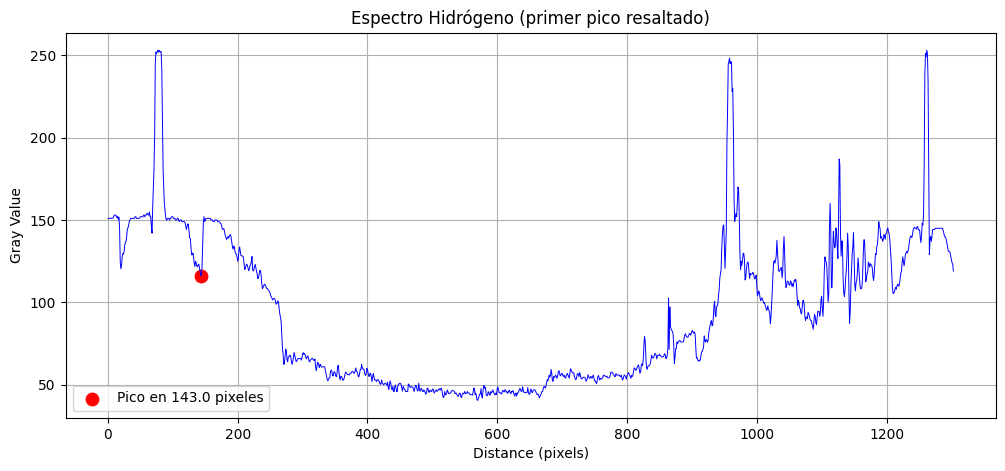

In [28]:
# Filtrar el rango 0–200 pixeles directamente
sub_df = df[(df["Distance_(pixels)"] >= 0) & (df["Distance_(pixels)"] <= 200)]

# Encontrar el mínimo
min_idx = sub_df["Gray_Value"].idxmin()
pico_x = sub_df.loc[min_idx, "Distance_(pixels)"]
pico_y = sub_df.loc[min_idx, "Gray_Value"]

print(f"Primer pico en el rango 0–200 pixeles:")
print(f"Pixel = {pico_x}, Intensidad = {pico_y}")

# Graficar con el pico resaltado
plt.figure(figsize=(12,5))
plt.plot(df["Distance_(pixels)"], df["Gray_Value"], linewidth=0.7, color="blue")
plt.scatter(pico_x, pico_y, color="red", s=80, label=f"Pico en {pico_x:.1f} pixeles")
plt.xlabel("Distance (pixels)")
plt.ylabel("Gray Value")
plt.title("Espectro Hidrógeno (primer pico resaltado)")
plt.legend()
plt.grid(True)
plt.show()


Primer pico en el rango 0–200 píxeles:
Pixel = 77.0, Intensidad = 253.0


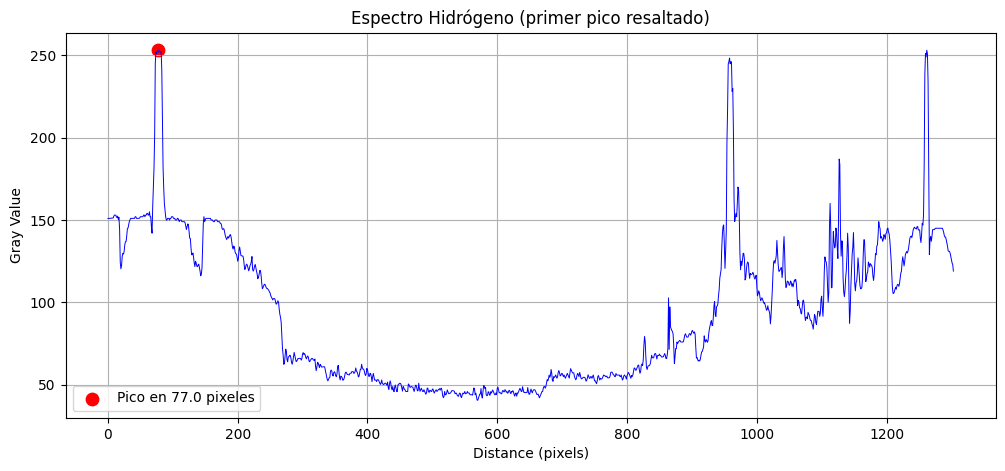

In [29]:
# Filtrar el rango 0–200 píxeles directamente
sub_df = df[(df["Distance_(pixels)"] >= 0) & (df["Distance_(pixels)"] <= 200)]

# Encontrar el máximo
max_idx = sub_df["Gray_Value"].idxmax()
pico_x = sub_df.loc[max_idx, "Distance_(pixels)"]
pico_y = sub_df.loc[max_idx, "Gray_Value"]

print(f"Primer pico en el rango 0–200 píxeles:")
print(f"Pixel = {pico_x}, Intensidad = {pico_y}")

# Graficar con el pico resaltado
plt.figure(figsize=(12,5))
plt.plot(df["Distance_(pixels)"], df["Gray_Value"], linewidth=0.7, color="blue")
plt.scatter(pico_x, pico_y, color="red", s=80, label=f"Pico en {pico_x:.1f} pixeles")
plt.xlabel("Distance (pixels)")
plt.ylabel("Gray Value")
plt.title("Espectro Hidrógeno (primer pico resaltado)")
plt.legend()
plt.grid(True)
plt.show()
